## Setup and Imports

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

print("Version information")

print("numpy: {}".format(np.__version__))
print("pandas: {}".format(pd.__version__))


Version information
numpy: 1.26.4
pandas: 2.2.3


## Preprocessing the Data

### Initializing global variables

In [3]:
DATA = '../Data/'
IMAGE_SIZE = (62, 124)
TEST_SPLIT = 0.3
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

### Loading the Images

In [4]:
mild = DATA + 'Mild Dementia/'
moderate = DATA + 'Moderate Dementia/'
non_demented = DATA + 'Non Demented/'
very_mild = DATA + 'Very Mild Dementia/'
data = []
labels = []
print("Loading data")
print("Loading Mild Dementia Images")
count = 0
for image in os.listdir(mild):
    file = os.path.join(mild, image)
    img = Image.open(file).resize(IMAGE_SIZE).convert("L")
    data.append(np.array(img).flatten())
    labels.append(0)
    count += 1
print("Loaded {} Mild Dementia Images".format(count))
count = 0
print("Loading Moderate Dementia Images")
for image in os.listdir(moderate):
    file = os.path.join(moderate, image)
    img = Image.open(file).resize(IMAGE_SIZE).convert("L")
    data.append(np.array(img).flatten())
    labels.append(1)
    count += 1
print("Loaded {} Moderate Dementia Images".format(count))
count = 0
print("Loading Non Demented Images")
for image in os.listdir(non_demented):
    file = os.path.join(non_demented, image)
    img = Image.open(file).resize(IMAGE_SIZE).convert("L")
    data.append(np.array(img).flatten())
    labels.append(2)
    count += 1
print("Loaded {} Non Demented Images".format(count))
count = 0
print("Loading Very Mild Dementia Images")
for image in os.listdir(very_mild):
    file = os.path.join(very_mild, image)
    img = Image.open(file).resize(IMAGE_SIZE).convert("L")
    data.append(np.array(img).flatten())
    labels.append(3)
    count += 1
print("Loaded {} Very Mild Dementia Images".format(count))
data = np.array(data)
labels = np.array(labels)

Loading data
Loading Mild Dementia Images
Loaded 5002 Mild Dementia Images
Loading Moderate Dementia Images
Loaded 488 Moderate Dementia Images
Loading Non Demented Images
Loaded 67222 Non Demented Images
Loading Very Mild Dementia Images
Loaded 13725 Very Mild Dementia Images


### Splitting the dataset

In [5]:
print(data.shape)
scaler = StandardScaler()
label_encoder = LabelEncoder()  
labels = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=TEST_SPLIT, random_state=42)

(86437, 7688)


### Reducing the Dimensions of our Data using PCA

In [6]:
pca = PCA(n_components=0.95)
X_train = scaler.fit_transform(X_train)
X_train = pca.fit_transform(X_train)

### Visualizing the Data in the New Feature Space

(60505, 954)


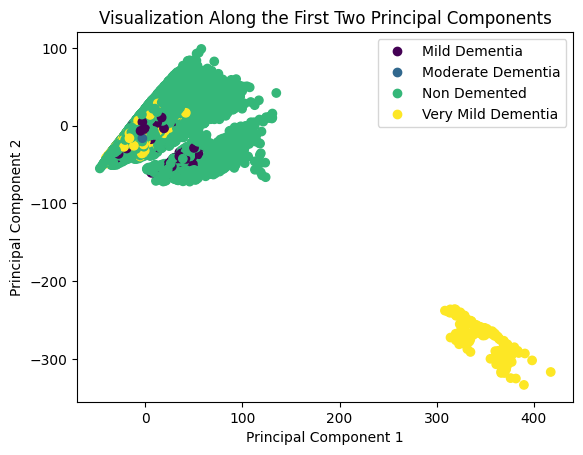

In [7]:
print(X_train.shape)
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
plt.title("Visualization Along the First Two Principal Components")
plt.legend(handles=scatter.legend_elements()[0], labels=['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very Mild Dementia'])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## Training  + Cross Validation

### Utilizing Cross Validation to find the best L2 Penalty Parameter

In [9]:
l_model = None
best = 0
C_vals = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []
for C in C_vals:
    model = LogisticRegression(C=C, tol = 0.01, max_iter = 10000, penalty = 'l2', solver = 'lbfgs')
    scores =  cross_val_score(model, X_train, y_train, cv=5, scoring = 'accuracy')
    results.append(scores.mean())
    if scores.mean() > best:
        best = scores.mean()
        l_model = model
    print("C: {}, Validation Accuracy: {}".format(C, scores.mean()))


C: 0.001, Validation Accuracy: 0.9197421700685894
C: 0.01, Validation Accuracy: 0.9228328237335758
C: 0.1, Validation Accuracy: 0.9220064457482853
C: 1, Validation Accuracy: 0.9235104536815137
C: 10, Validation Accuracy: 0.9239897529129824
C: 100, Validation Accuracy: 0.9223535245021074
C: 1000, Validation Accuracy: 0.9232790678456325


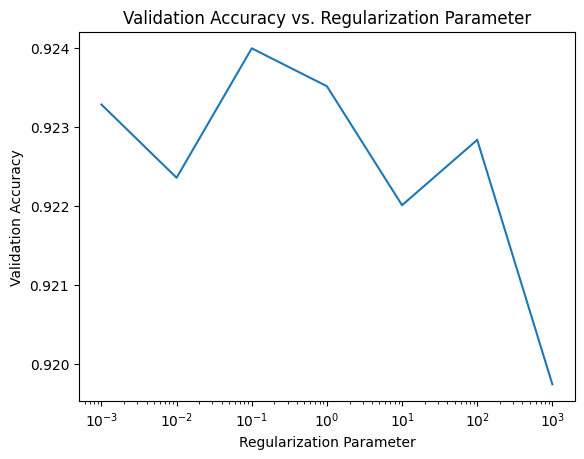

In [10]:
C_vals = np.array(C_vals)
plt.plot(1/C_vals, results)
plt.xscale('log')
plt.title("Validation Accuracy vs. Regularization Parameter")
plt.xlabel("Regularization Parameter")
plt.ylabel("Validation Accuracy")
plt.show()

Note: Per the scikit learn documentation, the parameter C for the Logistic Regression class is equal to the inverse of the L2 regularization parameter $\lambda$ that we are familiar with.

## Testing the Model

In [11]:
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)
l_model.fit(X_train, y_train)
results = l_model.score(X_test, y_test)
print("Test Accuracy: {}".format(results))

Test Accuracy: 0.9242634582754897


## Model Performance Evaluation and Visualization

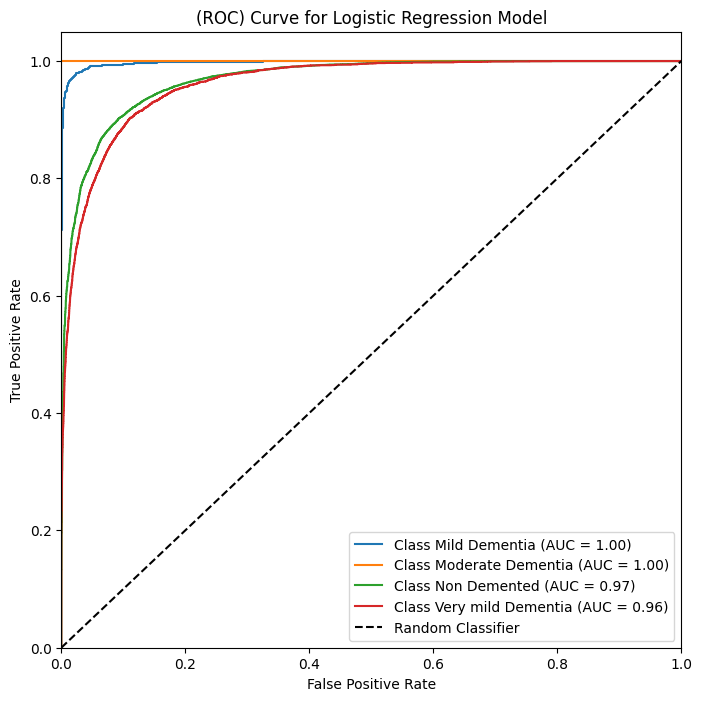

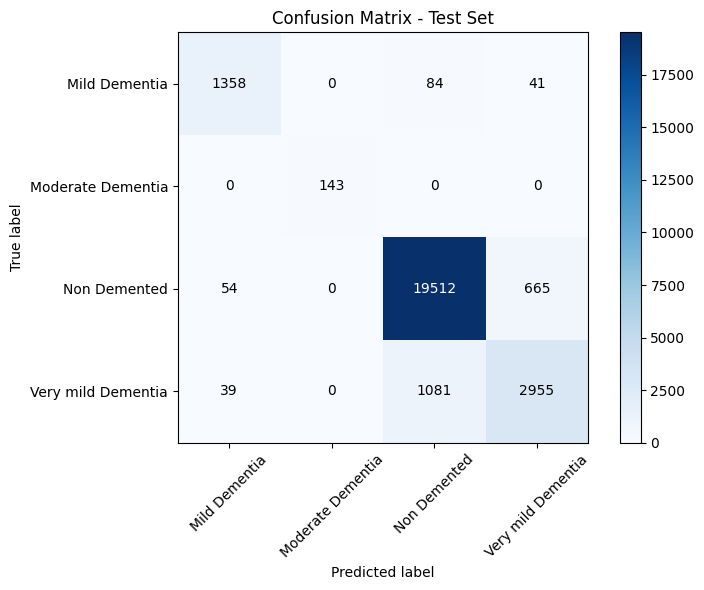

Accuracy: 0.924263
Precision: 0.921680
Recall: 0.901331
F1 Score: 0.910901


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize


# get the predicted probabilities and class labels
y_pred_proba = l_model.predict_proba(X_test) 
y_pred_labels = np.argmax(y_pred_proba, axis=1)

# binarize in order for roc curve
true_labels_bin = label_binarize(y_test, classes=range(len(classes)))

# prepare the roc curve and false/true positive rates
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot roc for each class
plt.figure(figsize=(8, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

# plot random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# roc plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()

# create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# add labels
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


# metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average="macro")
recall = recall_score(y_test, y_pred_labels, average="macro")
f1 = f1_score(y_test, y_pred_labels, average="macro")

print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")

